# CSU_RadarTools Demonstration

<hr>
<i>Notebook Author Info</i><br>
Timothy Lang<br>
tjlangco@gmail.com
<hr>

Welcome to the CSU_RadarTools demonstration IPython notebook. CSU_RadarTools is a collection of open-source tools for weather radar data quality control and analysis, written in the Python language. The package collates a disparate number of tools that have been developed over many years at Colorado State University. The purpose of this notebook is to demonstrate how to use the package to accomplish various tasks.

In order to get started, in addition to making sure you have a robust Python installation with most major tools (e.g., numpy, matplotlib, pandas, etc.) please download and install the following modules: 
<ul>
<li>CSU_RadarTools (https://github.com/CSU-RadarMet/CSU_RadarTools)
<li>Py-ART (https://github.com/ARM-DOE/pyart)
<li>SkewT (https://pypi.python.org/pypi/SkewT); Python 3 version available at https://github.com/tjlang/SkewT
</ul>

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pyart
import glob
from skewt import SkewT
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)
%matplotlib inline

First things first, you see that `csu_radartools` is actually several different sub-modules: 
<ul>
<li><b>`csu_fhc`</b> - fuzzy-logic hydrometeor identification</li>
<li><b>`csu_liquid_ice_mass`</b> - liquid/ice water mass calculations</li>
<li><b>`csu_blended_rain`</b> - rainfall estimation via the famous CSU blended algorithm</li> 
<li><b>`csu_dsd`</b> - DSD parameter estimation via several different methodologies</li> 
<li><b>`csu_kdp`</b> - An FIR-based KDP estimation algorithm</li>
<li><b>`csu_misc`</b> - A loose collection of miscellaneous tools, mainly focused on QC</li>
</ul>

Let's examine each sub-module in turn. First, however, let's define a simple function to do side-by-side PPI radar plots, powered by Py-ART.

In [2]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

<hr>

### csu_fhc

This package currently works with X-, C-, and S-band polarimetric radar data. Best results are obtained if you use a temperature sounding along with polarimetric radar data.

In [3]:
#Read in the data
sndfile = '/Users/tjlang/Documents/OVWST/CPOL/soundings/snd_Darwin.txt'
radarfile = '/Users/tjlang/Documents/OVWST/CPOL/output/20060119/' + \
    'cfrad.20060119_170029.000_to_20060121_020810.000_CPOL_v1_PPI.nc'
radar = pyart.io.read(radarfile)
print(radar.fields.keys())
sounding = SkewT.Sounding(sndfile)

[u'AD', u'KD', u'ZD', u'AH', u'DC', u'ZC', u'VR', u'DZ', u'FL', u'SR', u'PF', u'PH', u'RH', u'HD']


This volume is from the CPOL C-band polarimteric Doppler radar. The fields of note are corrected reflectivity (ZC), differential reflectivity (ZD), specific differential phase (KD), and correlation coefficient (RH). The sounding is a nearby sounding in the UWyo format (i.e., from http://weather.uwyo.edu/upperair/sounding.html).

The way CSU_RadarTools is designed is it works on Python arrays or scalars. This allows you to use it with any kind of radar data, whether it was ingested via Py-ART or something else, or is in polar coordinate or gridded form. Thus, we first need to extract the relevant fields from the Py-ART `radar` object.

In [4]:
dz = radar.fields['ZC']['data']
dr = radar.fields['ZD']['data']
kd = radar.fields['KD']['data']
rh = radar.fields['RH']['data']

But we also need to get the sounding data interpolated onto the same structure as the radar data. Here is a way to do that via Py-ART and `numpy.interp`.

In [8]:
def radar_coords_to_cart(rng, az, ele, debug=False):
    """
    TJL - taken from old Py-ART version
    Calculate Cartesian coordinate from radar coordinates
    Parameters
    ----------
    rng : array
        Distances to the center of the radar gates (bins) in kilometers.
    az : array
        Azimuth angle of the radar in degrees.
    ele : array
        Elevation angle of the radar in degrees.
    Returns
    -------
    x, y, z : array
        Cartesian coordinates in meters from the radar.
    Notes
    -----
    The calculation for Cartesian coordinate is adapted from equations
    2.28(b) and 2.28(c) of Doviak and Zrnic [1]_ assuming a
    standard atmosphere (4/3 Earth's radius model).
    .. math::
        z = \\sqrt{r^2+R^2+r*R*sin(\\theta_e)} - R
        s = R * arcsin(\\frac{r*cos(\\theta_e)}{R+z})
        x = s * sin(\\theta_a)
        y = s * cos(\\theta_a)
    Where r is the distance from the radar to the center of the gate,
    :math:\\theta_a is the azimuth angle, :math:\\theta_e is the
    elevation angle, s is the arc length, and R is the effective radius
    of the earth, taken to be 4/3 the mean radius of earth (6371 km).
    References
    ----------
    .. [1] Doviak and Zrnic, Doppler Radar and Weather Observations, Second
        Edition, 1993, p. 21.
    """
    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z


def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']


def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

And now we are ready to run the HID algorithm. Behold ...

In [9]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                T=radar_T)
fh = np.argmax(scores, axis=0) + 1

To enable the ability to find out the second-ranked (or third, etc.) species, `csu_fhc_summer` returns the scores for all the different categories, not just the max. So to get the traditional HID category number you have to use `numpy.argmax` as above. The summer HID from CSU returns 10 possible categories:
<ul>
<li>1. Drizzle</li>
<li>2. Rain</li>
<li>3. Ice Crystals</li>
<li>4. Aggregates</li>
<li>5. Wet/Melting Snow</li>
<li>6. Vertically Aligned Ice</li>
<li>7. Low-Density Graupel</li>
<li>8. High-Density Graupel</li>
<li>9. Hail</li>
<li>10. Big Drops</li>
</ul>

And these are represented as integers in the newly created `fh` array, which as the same structure as `dz`, `dr`, etc. We'd like to plot these data using Py-ART, which means we need to turn `fh` in a radar object field. Let's do that.

In [11]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='ZC'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

In [12]:
radar = add_field_to_radar_object(fh, radar)

And now let's plot it up! First, however, let's fix Py-ART's colorbars to look nice for HID and other category-style fields.

In [13]:
hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)
cmapmeth = colors.ListedColormap(hid_colors[0:6])
cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

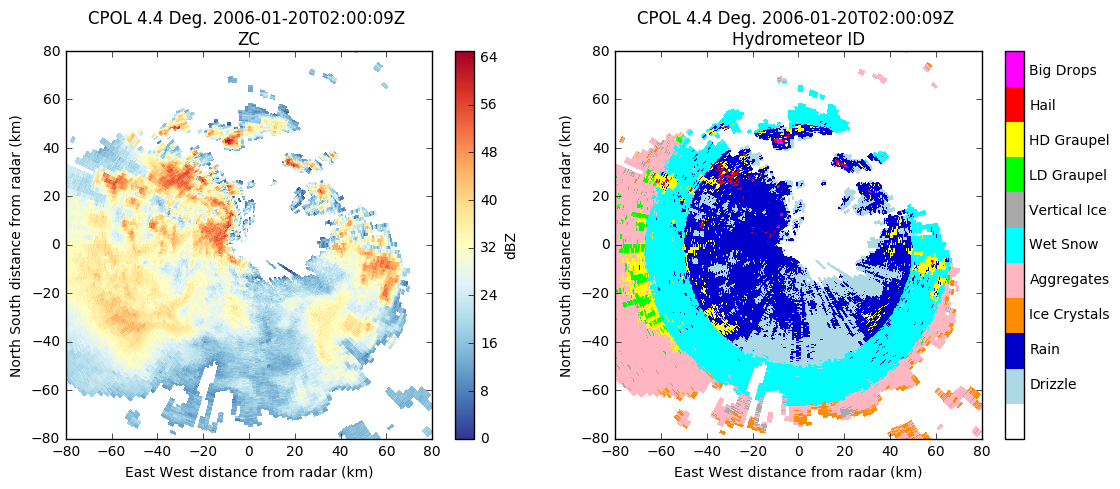

In [14]:
# Actual plotting done here
lim = [-80, 80]
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=5, var1='ZC', var2='FH', vmin2=0, vmax2=10,
    cmap2=cmaphid, units2='', return_flag=True, xlim=lim, ylim=lim)
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])

The HID algorithm, like most algorithms in CSU_RadarTools, works on scalars too. So if you are just curious what category a set of polarimetric values will get, try the following:

In [15]:
scores = csu_fhc.csu_fhc_summer(dz=45.0, zdr=0.0, kdp=-0.2, rho=0.95, T=-1) 
print(np.argmax(scores, axis=0) + 1)

8


... which is high-density graupel.

In [16]:
# Here's help to see what else you can do with csu_fhc.csu_fhc_summer
help(csu_fhc.csu_fhc_summer)

Help on function csu_fhc_summer in module csu_radartools.csu_fhc:

csu_fhc_summer(use_temp=True, weights={'DR': 0.8, 'DZ': 1.5, 'KD': 1.0, 'LD': 0.5, 'RH': 0.8, 'T': 0.4}, method='hybrid', dz=None, zdr=None, ldr=None, kdp=None, rho=None, T=None, verbose=False, plot_flag=False, n_types=10, temp_factor=1, band='S')
    Does FHC for warm-season precip.
    
    Arguments:
    use_temp = Set to False to not use T in HID
    weights = Dict that contains relative weights for every variable; see
              DEFAULT_WEIGHTS for expected stucture
    method = Currently support 'hybrid' or 'linear' methods; hybrid preferred
    verbose = Set to True to get text updates
    plot_flag = Flag to turn on optional beta function plots
    band = 'X', 'C', or 'S'
    temp_factor = Factor to modify depth of T effects; > 1 will broaden the
                  slopes of T MBFs
    n_types = Number of hydrometeor species
    verbose = Set to True to get text updates
    
    Input measurands (if not None, 

<hr>

### csu_liquid_ice_mass

In this module, we use difference reflectivity (ZDP) to derive separate ice and liquid water contributions to reflectivity, then use simple Z-M relationships to estimate mass contents. We can build on the above by using the same radar volume, sounding, etc. 

In [17]:
# Function expects, reflectivity, differential reflectivity, 
# and altitude (km MSL) at a minimum. 
# Temperature is optional.
mw, mi = csu_liquid_ice_mass.calc_liquid_ice_mass(dz, dr, radar_z/1000.0, T=radar_T)
radar = add_field_to_radar_object(mw, radar, field_name='MW', units='g m-3',
                                  long_name='Liquid Water Mass',
                                  standard_name='Liquid Water Mass')
radar = add_field_to_radar_object(mi, radar, field_name='MI', units='g m-3',
                                  long_name='Ice Water Mass',
                                  standard_name='Ice Water Mass')

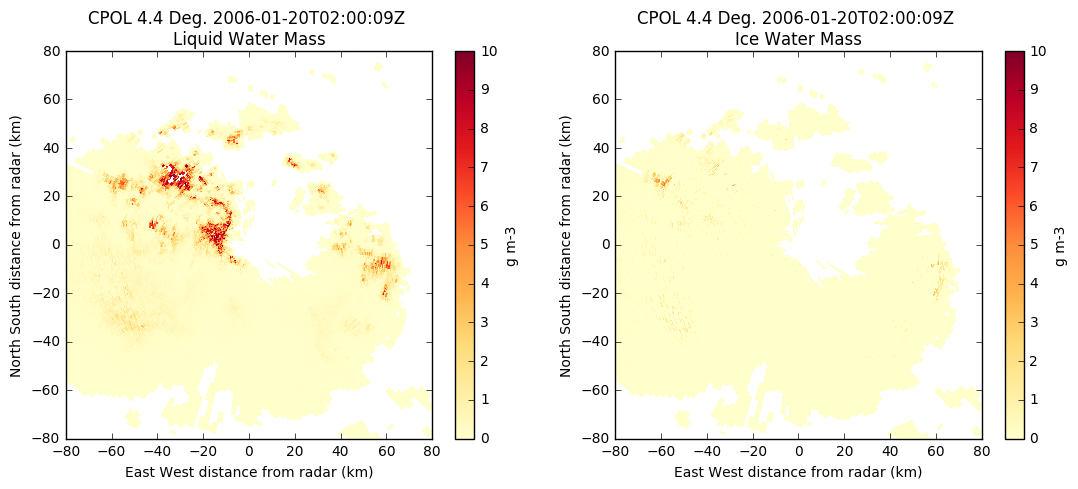

In [18]:
two_panel_plot(radar, sweep=5, var1='MW', var2='MI', vmin1=0, vmax1=10, vmin2=0, vmax2=10, 
               cmap1='YlOrRd', cmap2='YlOrRd', units1='g m-3', 
               units2='g m-3', xlim=lim, ylim=lim)

In [19]:
# Here's help to see what else you can do with csu_liquid_ice_mass.calc_liquid_ice_mass
help(csu_liquid_ice_mass.calc_liquid_ice_mass)

Help on function calc_liquid_ice_mass in module csu_radartools.csu_liquid_ice_mass:

calc_liquid_ice_mass(dbz, zdr, z, T=None, Hfrz=None, method='cifelli', fit_a=None, fit_b=None)
    This function uses the ZDP method to discriminate between
    
    Arguments:
    
    Must be same shape
    ------------------
    dbz = Reflectivity (dBZ)
    zdr = Differential Reflectivity (dB)
    z = Height (km MSL)
    T = Temperature (deg C)
    
    Other keywords
    --------------
    method = Name of method to determine fit_a and fit_b for rain line.
             Options are 'cifelli' and 'cr1995' which correspond to
             Cifelli et al. 2002 and Carey and Rutledge (1995). If you put
             anything else here, it will use Carey and Rutledge (2000).
    fit_a, fit_b = Fit coefficients to the rain line. If user doesn't specify,
                   then the reference specified in method will be used.
    
    Scalar only
    -----------
    Hfrz = Height of freezing level (km MSL), i

<hr>

### csu_blended_rain

This module provides access to two distinct CSU blended rainfall algorithm methodologies. The first function is `calc_blended_rain`, whcih is the classic version that utilizes ZDP to estimate ice fraction, and the second function is `calc_hidro_rain`, which is newer and uses HID to help distinguish regions of ice.

There are also a number of individual rain rate calculation functions (e.g., Z-R, R(Kdp), R(Z, Zdr), etc.) provided with this module. The user can specify the coefficients or just use the defaults, which come from standard literature references.

Output from the main blended functions include the method used at each gate, which the user can also plot up. For the example below we show the results from `calc_hidro_rain`. Since we already calculated HID, we can use our previous output from `csu_fhc` to supply that field.

In [20]:
rain, method = csu_blended_rain.csu_hidro_rain(dz=dz, zdr=dr, kdp=kd, fhc=fh)
radar = add_field_to_radar_object(rain, radar, field_name='rain', units='mm h-1',
                                  long_name='HIDRO Rainfall Rate', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(method, radar, field_name='method', units='',
                                  long_name='HIDRO Rainfall Method', 
                                  standard_name='Rainfall Method')

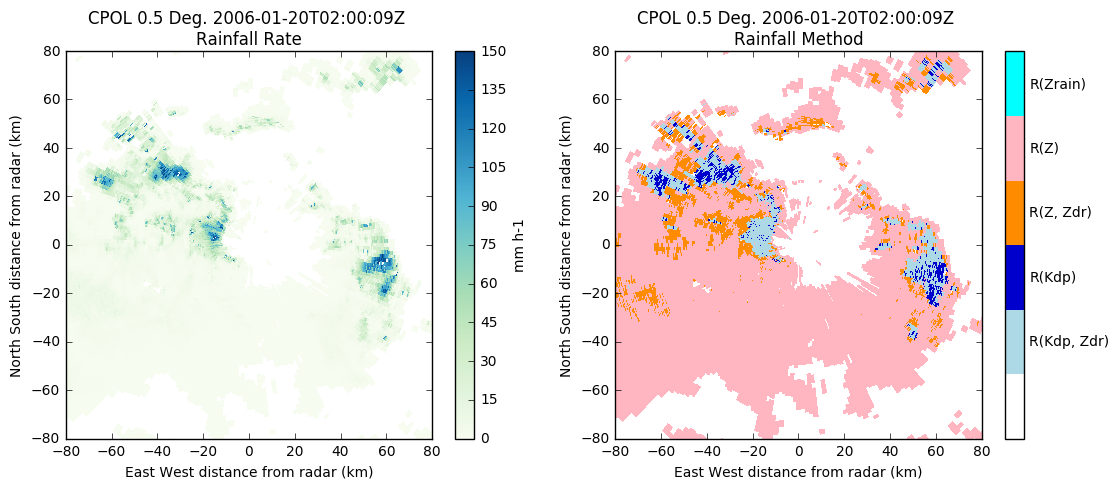

In [21]:
fig, ax1, ax2, display = two_panel_plot(radar, sweep=0, var1='rain', vmin1=0, vmax1=150,
                                        cmap1='GnBu', var2='method', vmin2=0, vmax2=5, 
                                        cmap2=cmapmeth, units2='', return_flag=True, 
                                        xlim=lim, ylim=lim, units1='mm h-1')
display.cbs[1] = adjust_meth_colorbar_for_pyart(display.cbs[1])

The method variable is an integer output that matches the following legend:

<u>Method Legend</u>
<ul>
<li>1. R(Kdp, Zdr)</li>
<li>2. R(Kdp)</li>
<li>3. R(Z, Zdr)</li>
<li>4. R(Z) - Z uncorrected to remove ice contamination</li>
<li>5. R(Zrain) - Z corrected to remove ice contamination</li>
</ul>

The last method is only used by `calc_blended_rain`. Here is how to use that algorithm. It has additional outputs, which include ZDP and ice fraction (unitless), if you set `ice_flag=True`.

In [22]:
rain, method, zdp, fi = csu_blended_rain.calc_blended_rain(dz=dz, zdr=dr, 
                                                           kdp=kd, ice_flag=True)
radar = add_field_to_radar_object(rain, radar, field_name='rain_blend', units='mm h-1',
                                  long_name='Blended Rainfall Rate', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(method, radar, field_name='method_blend', units='',
                                  long_name='Blended Rainfall Method', 
                                  standard_name='Rainfall Method')
radar = add_field_to_radar_object(zdp, radar, field_name='ZDP', units='dB',
                                  long_name='Difference Reflectivity',
                                  standard_name='Difference Reflectivity')
radar = add_field_to_radar_object(fi, radar, field_name='FI', units='', 
                                  long_name='Ice Fraction',
                                  standard_name='Ice Fraction')

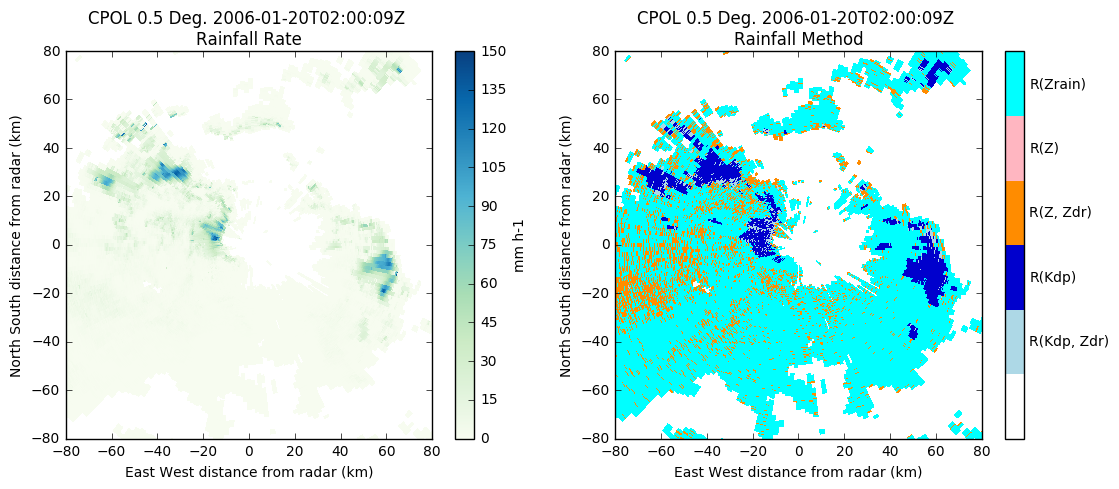

In [23]:
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=0, var1='rain_blend', vmin1=0, vmax1=150, cmap1='GnBu',
    var2='method_blend', vmin2=0, vmax2=5, cmap2=cmapmeth, units2='',
    return_flag=True, xlim=lim, ylim=lim, units1='mm h-1')
display.cbs[1] = adjust_meth_colorbar_for_pyart(display.cbs[1])

We can plot ZDP and FI too, to gauge how they are influencing the rainfall method choices seen above.

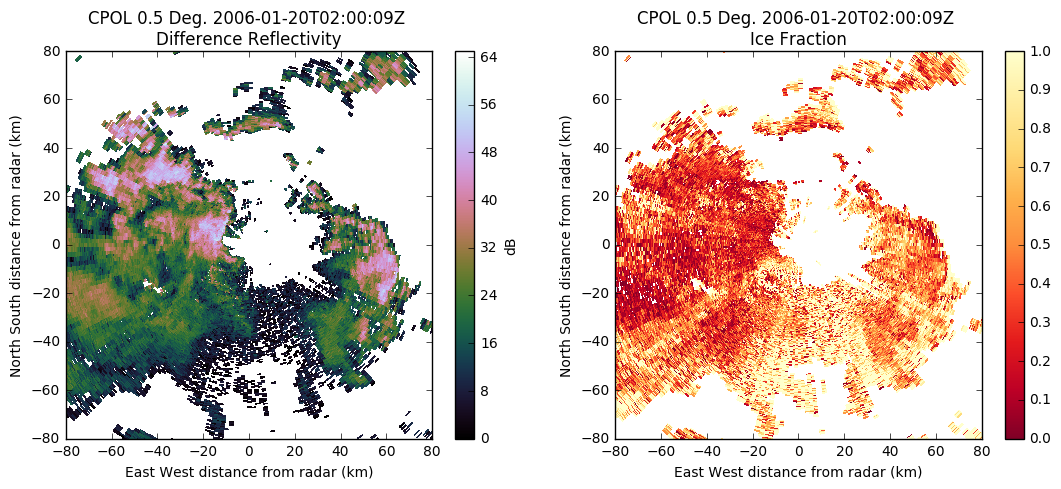

In [24]:
two_panel_plot(radar, sweep=0, var1='ZDP', units1='dB', vmin1=0, vmax1=65,
               cmap1='cubehelix', var2='FI', vmin2=0, vmax2=1, 
               cmap2='YlOrRd_r', units2='', xlim=lim, ylim=lim)

Of course, we are cheating here! In fact this is a C-band radar and by default the blended rain algorithms use S-band optimized parameters and logic. For C-band, it is best to rely not as much on Zdr due to resonance effects, so the logic excludes Zdr from consideration when `band != 'S'`. So let's make sure the blended rain algorithms know we are using C-band data, and provide them with custom C-band parameters for R-Z and R-Kdp. We'll also want to adjust the break points for Z (`thresh_dz`) and Kdp (`thresh_kdp`) in the logic. Values below either of these thresholds will cause the algorithm to rely on Z-R over R-Kdp.

In [25]:
rain, method = csu_blended_rain.csu_hidro_rain(
    dz=dz, zdr=dr, kdp=kd, fhc=fh, band='C', thresh_dz=35, thresh_kdp=0.15,
    r_z_a=200.0, r_z_b=1.4, r_kdp_a=29.71, r_kdp_b=0.85)
radar = add_field_to_radar_object(rain, radar, field_name='rain_C', units='mm h-1',
                                  long_name='HIDRO Rainfall Rate', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(method, radar, field_name='method_C', units='',
                                  long_name='HIDRO Rainfall Method', 
                                  standard_name='Rainfall Method')

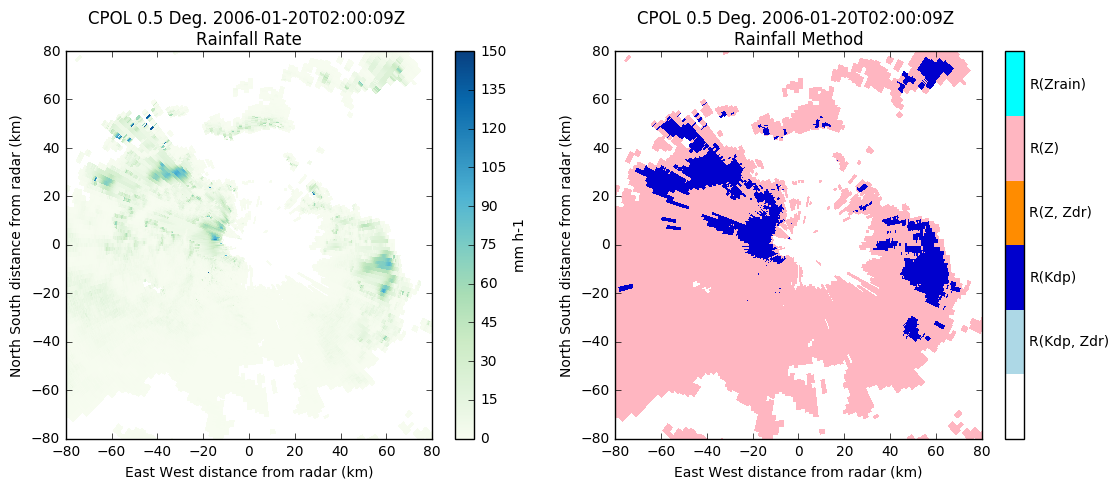

In [26]:
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=0, var1='rain_C', vmin1=0, vmax1=150,
    cmap1='GnBu', var2='method_C', vmin2=0, vmax2=5, 
    cmap2=cmapmeth, units2='', return_flag=True, 
    xlim=lim, ylim=lim, units1='mm h-1')
display.cbs[1] = adjust_meth_colorbar_for_pyart(display.cbs[1])

As can be seen, the list of method possibilities has been greatly simplified, while rain rate has been reduced overall because of the lower coefficient in `R = a*Kdp**b`. The same keywords can be used to change `csu_blended_rain.calc_blended_rain` too.

This logic is also the same for X-band (`band='X'`), with Zdr not used. However, again you will have to provide custom X-band parameters to the R-Kdp equation, and change `thresh_dz` and `thresh_kdp` (along with changing Z-R if desired).

<b>Please note that currently `csu_radartools` does not correct for attenuation at any frequency. This needs to be accounted for first before doing calculations, especially at X and C bands.</b>

For S-band, you may use additional custom parameters for the R(Kdp, Zdr) and R(Z, Zdr) equations by changing the `r_kdp_zdr_a`, `r_kdp_zdr_b`, and `r_kdp_zdr_c` keywords, and/or the `r_z_zdr_a`, `r_z_zdr_b`, and `r_z_zdr_c` keywords, respectively.

<hr>
There is a new method, called `csu_blended_rain.calc_blended_rain_tropical`, that can be used. It is tuned for tropical rainfall, so it is likely the better choice for rain estimates with the above Darwin, Australia case. Here is a quick demonstration of how to use.

In [27]:
help(csu_blended_rain.calc_blended_rain_tropical)

Help on function calc_blended_rain_tropical in module csu_radartools.csu_blended_rain_tropical:

calc_blended_rain_tropical(dz=None, zdr=None, kdp=None, cs=None, ice_flag=False, fhc=None, predef='True', band='S', thresh_dz=38.0, thresh_zdr=0.25, thresh_kdp=0.3, thresh_frac_ice=0.1, thresh_nexrad=53.0, r_z_a=216.0, r_z_b=1.39, r_z_a_c=126.0, r_z_b_c=1.39, r_z_a_s=291.0, r_z_b_s=1.55, r_kdp_a=59.5202, r_kdp_b=0.7451, r_z_zdr_a=0.0085, r_z_zdr_b=0.9237, r_z_zdr_c=-0.52389, fit_a=None, fit_b=None, method='cr1995', r_kdp_zdr_a=96.5726, r_kdp_zdr_b=0.9315, r_kdp_zdr_c=-0.21139999999999998)
    This algorithm ingests polarimetric radar data and computes rain rate,
    based on Thompson et al. 2016. Since ice is not expected at the surface in
    the tropics, the algorithm does not look for ice contamination.
    
    Inputs:
    dz = Reflectivity
    zdr = Differential Reflectivity
    kdp = Specific Differential Phase
    cs = Convective / Stratiform map (
        3=mixed / uncertain,
      

In [28]:
rain, method = csu_blended_rain.calc_blended_rain_tropical(dz=dz, zdr=dr, kdp=kd, fhc=fh, band='C')
radar = add_field_to_radar_object(rain, radar, field_name='rain_trop', units='mm h-1',
                                  long_name='Tropical Rainfall Rate', 
                                  standard_name='Rainfall Rate')
radar = add_field_to_radar_object(method, radar, field_name='method_trop', units='',
                                  long_name='Tropical Rainfall Method', 
                                  standard_name='Rainfall Method')

Note that there are additional methods to display, so we have to change `vmax`, the colormap, and also use the `tropical=True` flag below. The tropical algorithm is still under development, so use with caution.

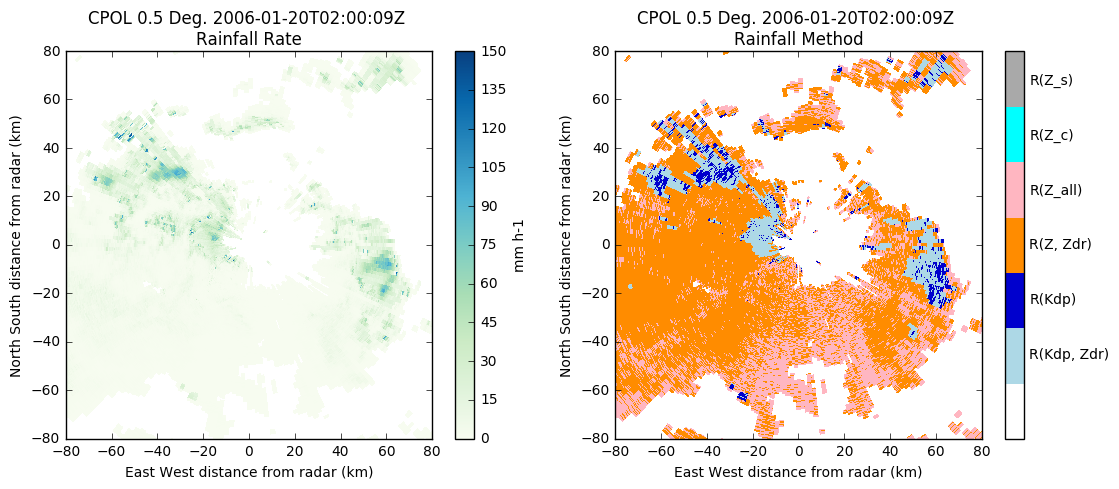

In [29]:
fig, ax1, ax2, display = two_panel_plot(
    radar, sweep=0, var1='rain_trop', vmin1=0, vmax1=150,
    cmap1='GnBu', var2='method_trop', vmin2=0, vmax2=6, 
    cmap2=cmapmeth_trop, units2='', return_flag=True, 
    xlim=lim, ylim=lim, units1='mm h-1')
display.cbs[1] = adjust_meth_colorbar_for_pyart(display.cbs[1], tropical=True)

In [30]:
# And of course, we can get help on all the other stuff!
help(csu_blended_rain)

Help on module csu_radartools.csu_blended_rain in csu_radartools:

NAME
    csu_radartools.csu_blended_rain - csu_blended_rain.py

FILE
    /Users/tjlang/anaconda/lib/python2.7/site-packages/csu_radartools/csu_blended_rain.py

DESCRIPTION
    # Brody Fuchs, CSU, Oct 2014
    # brfuchs@atmos.colostate.edu
    
    # python remake of Brenda's code to calculate water and ice mass
    
    Amendments by
    Timothy Lang (tjlangco@gmail.com)
    2/20/2015
    rev1 07/10/2015
    rev2 08/03/2015 - Python 3
    rev3 09/16/2015 - Fixed logical inconsistencies leading to lack of
                      rainfall calculation in HID = rain + low Z + high Kdp/Zdr
    rev4 05/10/2016 - Added ability for user to provide custom parameters to
                      polarimetric rainfall equations via the blended rainfall
                      routines. Also customized blended routines to handle
                      non-S bands. In this case, only R-Z and R-Kdp are used.
    rev5 07/28/2016 - Moved base r

Finally, there are individual functions for rainfall, like R(Kdp) and R(Z, Zdr). So you can just access those on your own, if you like.

In [31]:
rkdp = csu_blended_rain.calc_rain_kdp(kd, a=29.71, b=0.85)
radar = add_field_to_radar_object(rkdp, radar, field_name='rkdp', units='mm h-1',  
                                  long_name='Rainfall Rate R(Kdp)', 
                                  standard_name='Rainfall Rate')

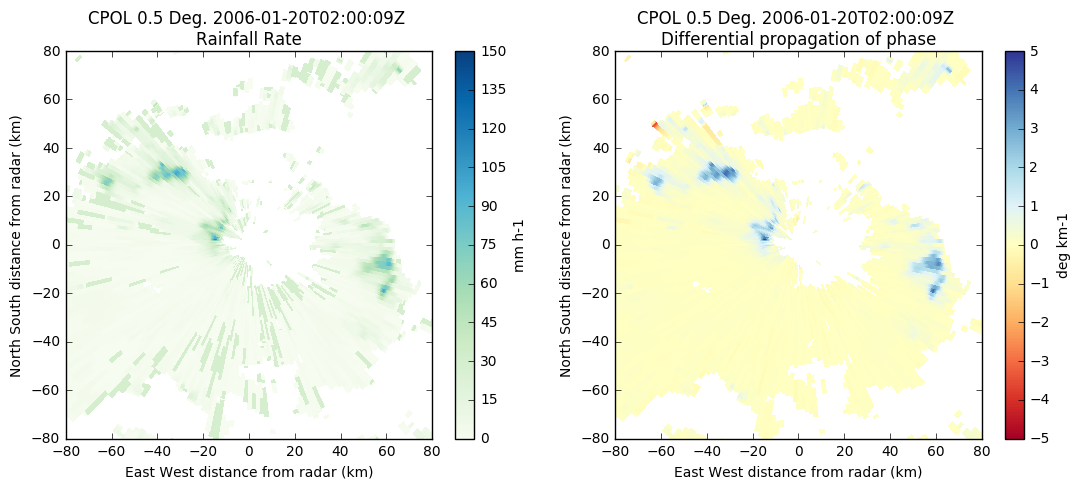

In [32]:
# Compare R(Kdp) with Kdp!
two_panel_plot(radar, sweep=0, var1='rkdp', vmin1=0, vmax1=150, 
               cmap1='GnBu', units1='mm h-1',
               var2='KD', vmin2=-5, vmax2=5, cmap2='RdYlBu', 
               units2='deg km-1', xlim=lim, ylim=lim)

<hr>

### csu_dsd

This module enables retrieval of common drop-size distribution (DSD) parameters. As with most aspects of CSU_RadarTools, the end user is responsible for proper masking of their data, as DSD retrievals are only valid in pure rain. Remember, garbage in = garbage out! The module is designed to work with C-band or S-band, and the retrievals are different depending on radar frequency. The main function is `calc_dsd` and it returns median volume diameter (D0), normalized intercept parameter (Nw), and mu assuming a gamma distribution DSD model.

Let's first check things out for C-band.

In [33]:
d0, Nw, mu = csu_dsd.calc_dsd(dz=dz, zdr=dr, kdp=kd, band='C')
radar = add_field_to_radar_object(d0, radar, field_name='D0', units='mm', 
                                  long_name='Median Volume Diameter',
                                  standard_name='Median Volume Diameter')
logNw = np.log10(Nw)
radar = add_field_to_radar_object(logNw, radar, field_name='NW', units='', 
                                  long_name='Normalized Intercept Parameter',
                                  standard_name='Normalized Intercept Parameter')
radar = add_field_to_radar_object(mu, radar, field_name='MU', units='', 
                                  long_name='Mu', standard_name='Mu')

The C-band retrievals, based on Bringi et al. (2009), don't bother retrieving mu. So CSU_RadarTools will fix it at 3 unless the end user changes the `csu_dsd.DEFAULT_MU` global variable. So let's check out instead what happened with D0 and Nw.

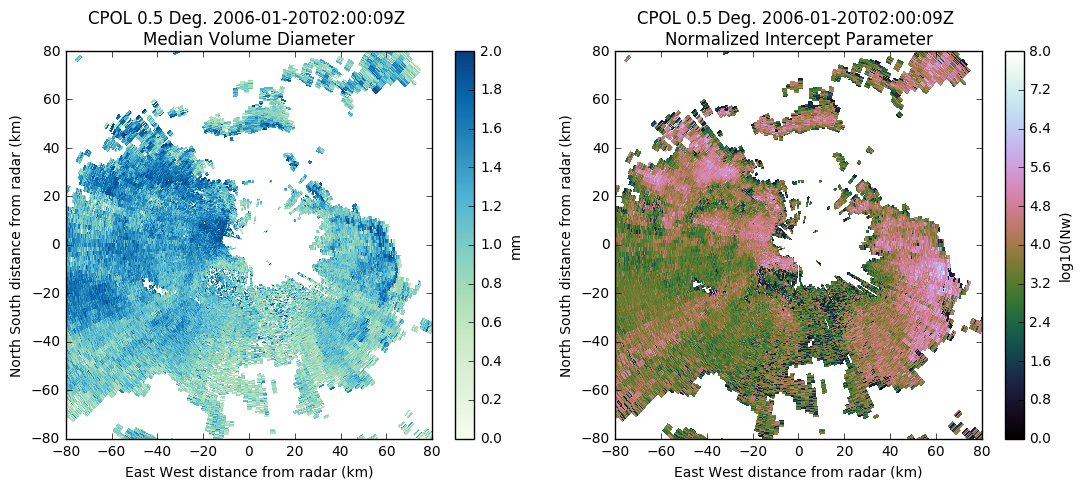

In [34]:
two_panel_plot(radar, sweep=0, var1='D0', vmin1=0, vmax1=2, cmap1='GnBu', units1='mm',
               var2='NW', vmin2=0, vmax2=8, cmap2='cubehelix', units2='log10(Nw)', xlim=lim, 
               ylim=lim)

Note the differences in D0 & Nw pairs inside and outside of convection. Both here and above with ice fraction, which also depends heavily on Zdr, there are some possible differential attenuation impacts on the retrievals downrange of one of the cores just west of the radar.

What about S-band DSD retrievals? For that we need a different radar. Let's try S-PolKa during the NAME project in 2004.

In [35]:
fdir = '/Users/tjlang/Documents/OVWST/NAME/output/20040805/'
files = sorted(glob.glob(fdir+'*nc'))
radarS = pyart.io.read(files[0])
print(radarS.fields.keys())

[u'LD', u'KD', u'ZD', u'DR', u'DB', u'VR', u'HI', u'FD', u'DZ', u'PH', u'RH', u'SD']


In [36]:
dzS = radarS.fields['DZ']['data']
drS = radarS.fields['DR']['data']
kdS = radarS.fields['KD']['data']

With S-band, there are two different methodologies available: Bringi et al. (2013) and Bringi et al. (2004). The latter allows mu to vary, so let's try that.

In [37]:
d0, Nw, mu = csu_dsd.calc_dsd(dz=dzS, zdr=drS, kdp=kdS, band='S', method='2004')
radarS = add_field_to_radar_object(d0, radarS, field_name='D0', units='mm', 
                                   long_name='Median Volume Diameter',
                                   standard_name='Median Volume Diameter', dz_field='DZ')
logNw = np.log10(Nw)
radarS = add_field_to_radar_object(logNw, radarS, field_name='NW', units='', 
                                   long_name='Normalized Intercept Parameter',
                                   standard_name='Normalized Intercept Parameter', 
                                   dz_field='DZ')
radarS = add_field_to_radar_object(mu, radarS, field_name='MU', units='', long_name='Mu', 
                                   standard_name='Mu', dz_field='DZ')

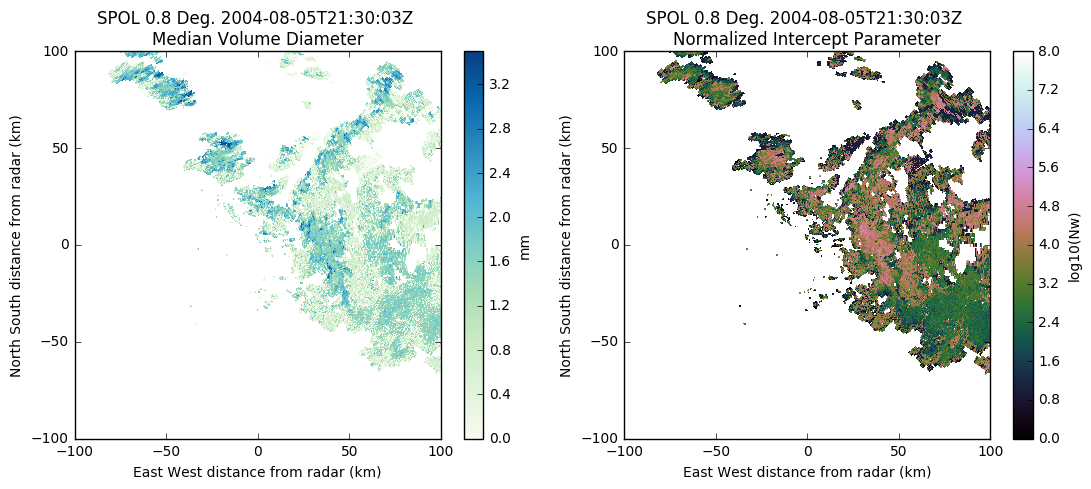

In [38]:
limS = [-100, 100]
# Changing the color scale a bit to allow for the bigger drops in this case. 
two_panel_plot(radarS, sweep=0, var1='D0', vmin1=0, vmax1=3.5, cmap1='GnBu', units1='mm',
               var2='NW', vmin2=0, vmax2=8, cmap2='cubehelix', units2='log10(Nw)', xlim=limS, 
               ylim=limS)

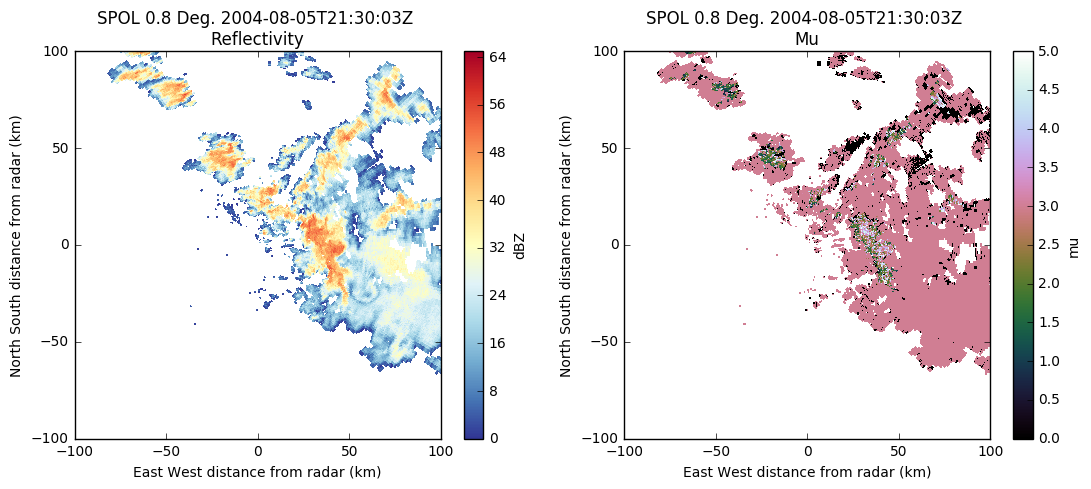

In [39]:
# Now let's see what mu is up to ...
two_panel_plot(
    radarS, sweep=0, var1='DZ', vmin1=0, vmax1=65, cmap1='RdYlBu_r', units1='dBZ',
    var2='MU', vmin2=0, vmax2=5, cmap2='cubehelix', units2='mu', xlim=limS, ylim=limS)

So for the most part mu gets set to 3, except there is some variability in the cores and a few other places. Normally, mu is very difficult to retrieve accurately, but at least the user has the option of testing different methodologies with `csu_dsd`.

In [40]:
# And you can always ...
help(csu_dsd)

Help on module csu_radartools.csu_dsd in csu_radartools:

NAME
    csu_radartools.csu_dsd

FILE
    /Users/tjlang/anaconda/lib/python2.7/site-packages/csu_radartools/csu_dsd.py

DESCRIPTION
    #############
    csu_dsd sub-module of csu_radartools
    
    Contacts
    --------
    Brenda Dolan (dolan@atmos.colostate.edu)
    Timothy Lang (tjlangco@gmail.com)
    
    References
    ----------
    Bringi et al. (2004; JTECH) - Alternate S-band retrieval
    Bringi et al. (2009; JTECH) - C-band retrieval
    Bringi et al. (2013; AMS Radar Conf) - S-band retrieval
    
    rev1 (07/28/2016) - Changed import location for _check_for_array
    
    #############

FUNCTIONS
    calc_Nw_mult_methods(dz, d0)
        Bringi et al. (2004) Eqs. A.17, A.19, A.21
    
    calc_beta(dz, kdp, zeta, a=2.08, b=-0.365, c=0.38, d=0.965)
        Bringi et al. (2004) Eq. A.1
    
    calc_d0_sband_method1(dz, zeta, beta, a=0.56, b=0.064, c=0.024, d=-1.42)
        Bringi et al. (2004) Eqs. A.2-A.5
    
   

<hr>

### csu_kdp

This module supplies a simple way of estimating specific differential phase (Kdp) via a methodology developed in the CSU Department of Electrical Engineering, and then subsequently adapted and used in the Department of Atmospheric Science. Filtering of the input differential phase field is based on a finite impulse response (FIR) filter, applied in a moving adjustable-length window. Then, an adaptive linear fit is applied iteratively to the filtered phase field, where half the slope of the linear fit at any specific gate is the Kdp estimate. The length of the line needed (i.e., number of gates considered) depends on the reflectivity at the gate in question. 

Standard deviation of differential phase is estimated and used to remove noisy/bad data. Gaps are filled in the filter window if the holes are less than 20% of the window length. To use this module you need a gate spacing that divdes evenly into the window length km (e.g., 150 m gate spacing divides evenly into a 3 km filter window). Let's get started with a NEXRAD example.

In [45]:
fdirN = '/Users/tjlang/Documents/OVWST/NEXRAD/'
filesN = sorted(glob.glob(fdirN + 'KAMX/KAMX*'))
radarN = pyart.io.read(filesN[0])
print(radarN.fields.keys())

['differential_phase', 'cross_correlation_ratio', 'spectrum_width', 'reflectivity', 'differential_reflectivity', 'velocity']


In [46]:
def extract_unmasked_data(radar, field, bad=-32768):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

In [47]:
dzN = extract_unmasked_data(radarN, 'reflectivity')
dpN = extract_unmasked_data(radarN, 'differential_phase')
# Range needs to be supplied as a variable, and it needs to be the same shape as dzN, etc.
rng2d, az2d = np.meshgrid(radarN.range['data'], radarN.azimuth['data'])

OK, now we have all our needed inputs to calculate Kdp. The function we will call is `csu_kdp.calc_kdp_bringi`, and it returns Kdp, filtered differential phase, and standard deviation of differential phase, in that order. Input variables can be 1D (rays) or 2D (azimuth/elevation and rays). The fundamental algorithm works on a ray-by-ray basis.

In [48]:
import time
bt = time.time()
kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(
    dp=dpN, dz=dzN, rng=rng2d/1000.0, thsd=12, gs=250.0, window=5)
print(time.time()-bt, 'seconds to run')

1.62439489365 seconds to run


The `gs` keyword is the gate spacing that the radar data use, in meters. The `window` keyword is the length (km) over with to apply the phase filtering. Default is 3 km. The `thsd` keyword is the threshold to apply to the standard deviation of differential phase (deg). OK, let's see what happened.

In [49]:
radarN = add_field_to_radar_object(kdN, radarN, field_name='KDP', units='deg/km', 
                                   long_name='Specific Differential Phase',
                                   standard_name='Specific Differential Phase', 
                                   dz_field='reflectivity')
radarN = add_field_to_radar_object(fdN, radarN, field_name='FDP', units='deg', 
                                   long_name='Filtered Differential Phase',
                                   standard_name='Filtered Differential Phase', 
                                   dz_field='reflectivity')
radarN = add_field_to_radar_object(sdN, radarN, field_name='SDP', units='deg', 
                                   long_name='Standard Deviation of Differential Phase',
                                   standard_name='Standard Deviation of Differential Phase', 
                                   dz_field='reflectivity')

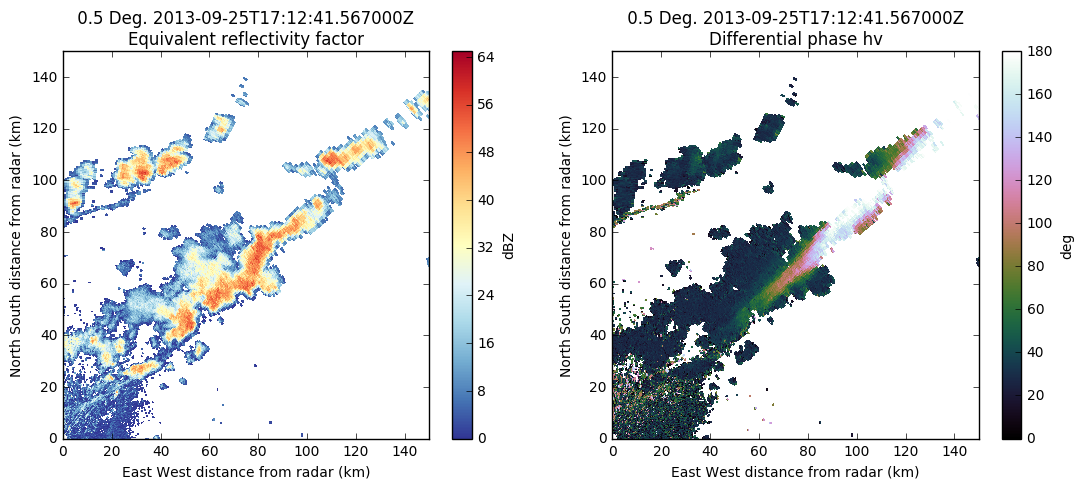

In [50]:
#First let's see what the original data looked like.
limN = [0, 150]
two_panel_plot(radarN, sweep=0, var1='reflectivity', vmin1=0, vmax1=65.0, 
               cmap1='RdYlBu_r', units1='dBZ',
               var2='differential_phase', vmin2=0, vmax2=180, 
               cmap2='cubehelix', units2='deg', 
               xlim=limN, ylim=limN)

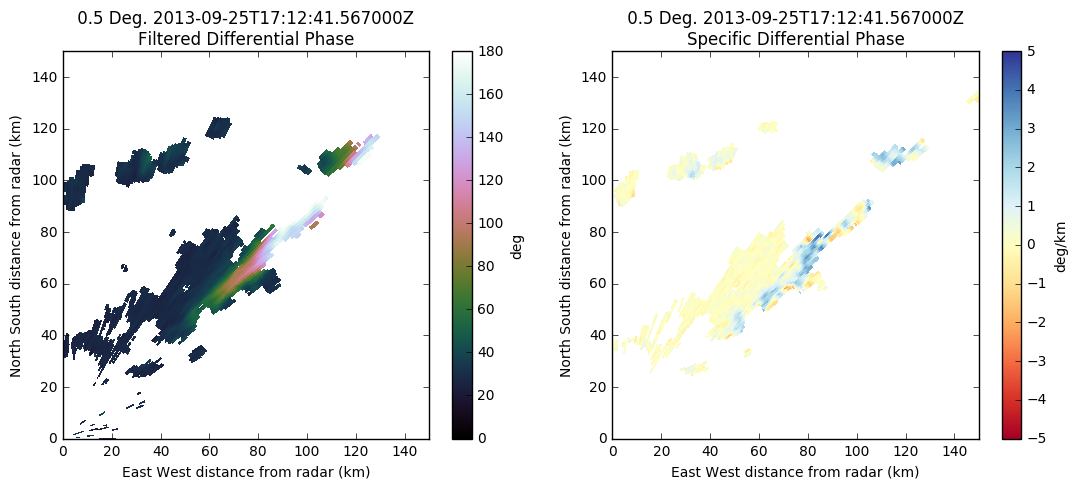

In [51]:
#Now let's see the filtered and specific differential phase fields
two_panel_plot(radarN, sweep=0, var1='FDP', vmin1=0, vmax1=180, 
               cmap1='cubehelix', units1='deg',
               var2='KDP', vmin2=-5, vmax2=5, cmap2='RdYlBu', units2='deg/km', 
               xlim=limN, ylim=limN)

If window is too short, the resultant Kdp field is a little checkerboard-ish. That is a known characteristic of this algorithm. Due to the along-ray alignment of the storm, there is a lot of phase shift and possibly even some backscatter effects, and that is also a contributor. The best and most reliable results are obtained in the heavier cores, as expected.

One very nice aspect of this algorithm is it returns the standard deviation of differential phase. You may notice the removal of substantial clear-air echo in the processed phase fields. This is the standard deviation thresholding (`thsd` keyword) in effect. More on that in our next tutorial section. 

In [52]:
#but first ...
help(csu_kdp.calc_kdp_bringi)

Help on function calc_kdp_bringi in module csu_radartools.csu_kdp:

calc_kdp_bringi(dp=None, dz=None, rng=None, thsd=12, nfilter=1, bad=-32768, gs=150.0, window=3.0, std_gate=11)
    Overview
    --------
    This is an old algorithm that uses an FIR filter to process differential
    phase and extract specific differential phase. It works on polarimetric
    radar data. It is based on code provided by V. N. Bringi and Yanting Wang
    of CSU Electrical Engineering. It assumes differential phase has been
    unfolded already. You can send this function either 1D or 2D arrays of
    data. If 2D, it assumes the first index is azimuth so it will loop over
    that, calculating KDP along individual rays.
    
    Steps
    -----
    1. Standard deviation of differential phase is calculated and used to
       QC the phase data. The stdev calculation uses up to std_gate consecutive
       gates regardless of gate spacing.
    2. Differential phase is filtered using the FIR filter, which has 

<hr>

### csu_misc

This module is a hodgepodge of various algorithms, most of them focused on quality control. They are a series of functions that return masks. Apply the masks to your radar data to clean them up. Let's see how this works in practice, continuing from the previous section.

In [53]:
drN = extract_unmasked_data(radarN, 'differential_reflectivity')
insect_mask = csu_misc.insect_filter(dzN, drN)
sdp_mask = csu_misc.differential_phase_filter(sdN, thresh_sdp=13)

In [54]:
bad = -32768
dz_insect = 1.0 * dzN
dz_insect[insect_mask] = bad
dz_sdp = 1.0 * dzN
dz_sdp[sdp_mask] = bad

In [55]:
radarN = add_field_to_radar_object(dz_insect, radarN, field_name='DZ_insect', units='dBZ', 
                                   long_name='Reflectivity (Insect Filtered)',
                                   standard_name='Reflectivity (Insect Filtered)', 
                                   dz_field='reflectivity')
radarN = add_field_to_radar_object(dz_sdp, radarN, field_name='DZ_sdp', units='dBZ', 
                                   long_name='Reflectivity (Phase Filtered)',
                                   standard_name='Reflectivity (Phase Filtered)', 
                                   dz_field='reflectivity')

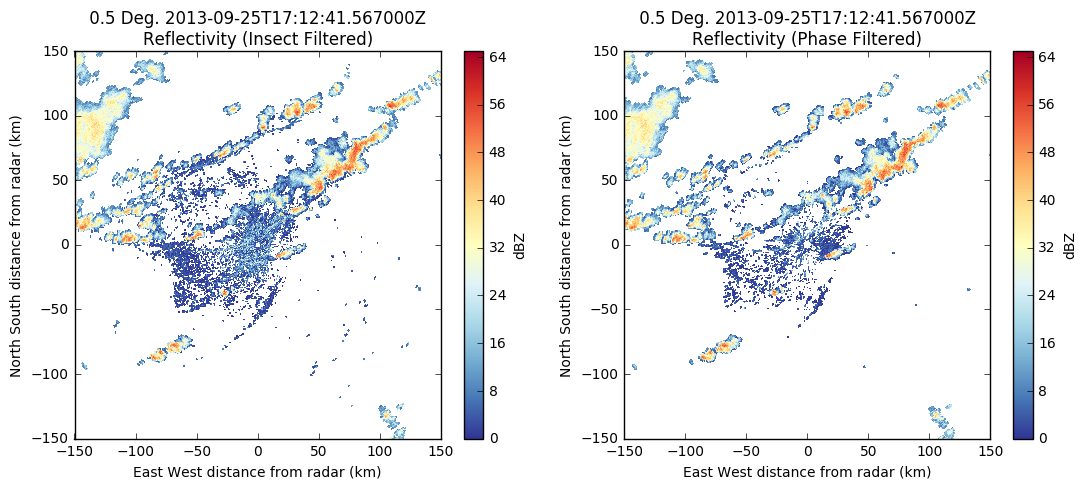

In [56]:
limN = [-150, 150]
two_panel_plot(radarN, sweep=0, var1='DZ_insect', vmin1=0, vmax1=65, 
               cmap1='RdYlBu_r', units1='dBZ',
               var2='DZ_sdp', vmin2=0, vmax2=65, cmap2='RdYlBu_r', units2='dBZ', 
               xlim=limN, ylim=limN)

Of course, the real power will come by combining multiple filters together. And then we can despeckle to remove most remaining spurious echo.

In [57]:
new_mask = np.logical_or(insect_mask, sdp_mask)
dz_qc = 1.0 * dzN
dz_qc[new_mask] = bad
dz_pre_despeck = 1.0 * dz_qc
mask_ds = csu_misc.despeckle(dz_qc, ngates=4)
dz_qc[mask_ds] = bad
radarN = add_field_to_radar_object(dz_qc, radarN, field_name='DZ_qc', units='dBZ', 
                                   long_name='Reflectivity (Combo Filtered)',
                                   standard_name='Reflectivity (Combo Filtered)', 
                                   dz_field='reflectivity')
radarN = add_field_to_radar_object(dz_pre_despeck, radarN, 
                                   field_name='DZ_before', units='dBZ', 
                                   long_name='Reflectivity (No Despeckling)',
                                   standard_name='Reflectivity (No Despeckling)', 
                                   dz_field='reflectivity')

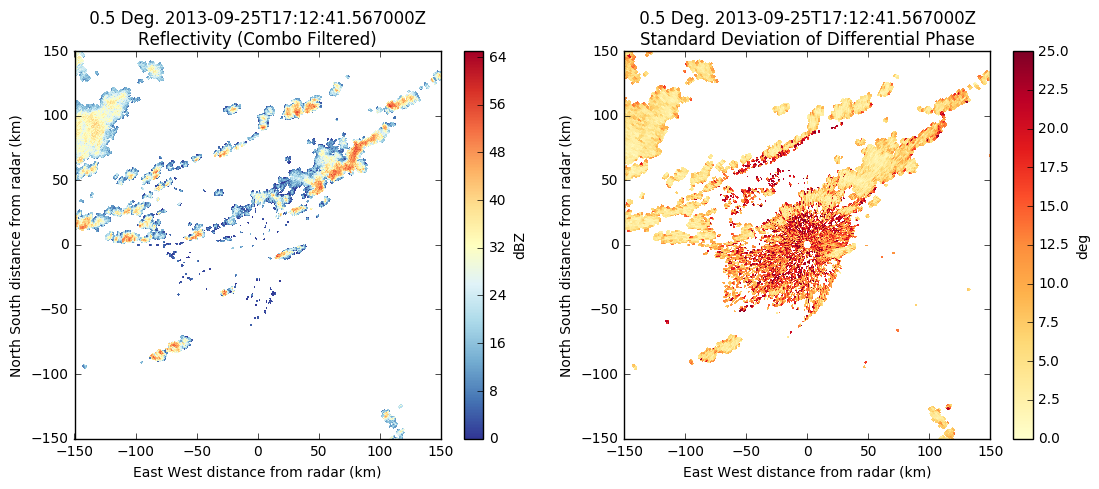

In [58]:
limN = [-150, 150]
two_panel_plot(radarN, sweep=0, var1='DZ_qc', vmin1=0, vmax1=65, 
               cmap1='RdYlBu_r', units1='dBZ',
               var2='SDP', vmin2=0, vmax2=25, cmap2='YlOrRd', units2='deg', 
               xlim=limN, ylim=limN)

The way `csu_misc.insect_filter` works is it looks in various reflectivity ranges. If differential reflectivity exceeds a given threshold in that range, the data are flagged as likely insects (or other biological scatterers). The defaults are some values that were tuned for the NAME project.


In [59]:
print(csu_misc.DEFAULT_DZ_RANGE)
print(csu_misc.DEFAULT_DR_THRESH)

[[-100, 10], [10, 15], [15, 20], [20, 25], [25, 30], [30, 35]]
[1, 1.3, 1.7, 2.1, 2.5, 2.8]


So below 10 dBZ, if Zdr exceeds 1 dB the data are flagged, for Zh = 10-15 dBZ then Zdr above 1.3 dB is flagged, etc. The user can make their own thresholds by adjusting the `dz_range` and `dr_thresh` keywords in csu_misc.insect_filter(). The `dz_range` keyword expects a list of 2-element tuples (lower and upper bounds for reflectivity) and `dr_thresh` expects a list of scalars (Zdr threshold value).

In [60]:
#Here is more info
help(csu_misc.insect_filter)

Help on function insect_filter in module csu_radartools.csu_misc:

insect_filter(dz, zdr, height=None, mask=None, dz_range=[[-100, 10], [10, 15], [15, 20], [20, 25], [25, 30], [30, 35]], dr_thresh=[1, 1.3, 1.7, 2.1, 2.5, 2.8], bad=-32768)
    Returns a mask that identifies potentially suspect gates due to presence of
    biological scatterers.



Let's see how the despeckle filter works by examining before and after behavior.

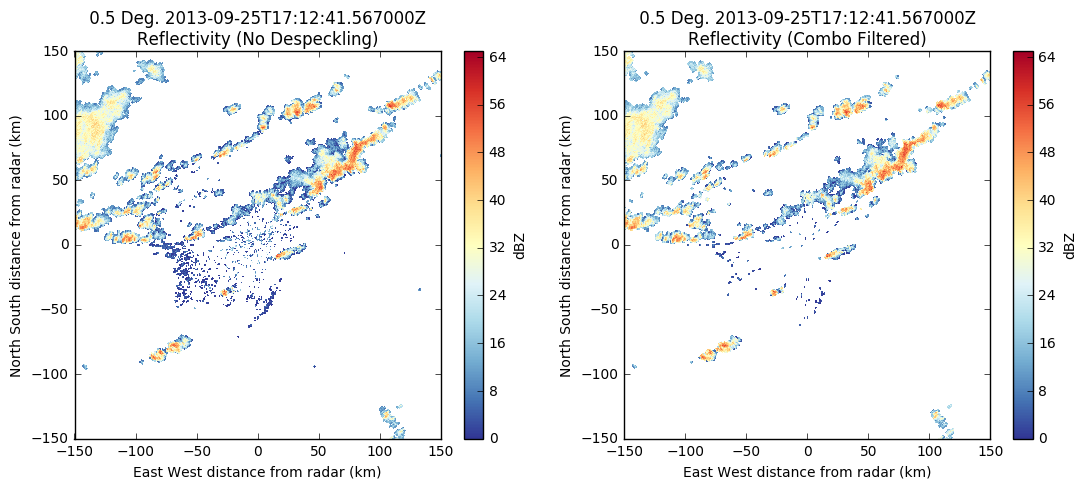

In [61]:
limN = [-150, 150]
two_panel_plot(radarN, sweep=0, var1='DZ_before', vmin1=0, vmax1=65, 
               cmap1='RdYlBu_r', units1='dBZ',
               var2='DZ_qc', vmin2=0, vmax2=65, cmap2='RdYlBu_r', units2='dBZ', 
               xlim=limN, ylim=limN)

So, it gets rid of short, standalone "specks" of echo. The user can change how many gates they want to count as a speck via the `ngates` keyword. Feel free to vary the despeckling length and SDP threshold to suit your desire for elimination of non-meteorological echo. We could also play with the Zh/Zdr thresholds in the insect filter. But by and large, for the settings we used, the worst of the non-meteorological echo is removed. That is good enough for a demonstration!

In [62]:
# More info
help(csu_misc.despeckle)

Help on function despeckle in module csu_radartools.csu_misc:

despeckle(data, bad=-32768, ngates=4)
    data = 1-D or 2-D array of radar data (e.g., reflectivity) to despeckle.
           If 1-D, should be a single ray. If 2-D, first dimension should be
           azimuth/elevation and second should be range.
    bad = Bad data value to check against
    ngates = Number of contiguous good data gates required along ray for no
             masking to occur
    
    Returns mask w/ same shape as data. True = bad.



   There are a few other basic filters, but you can find all that out by ...

In [63]:
help(csu_misc)

Help on module csu_radartools.csu_misc in csu_radartools:

NAME
    csu_radartools.csu_misc

FILE
    /Users/tjlang/anaconda/lib/python2.7/site-packages/csu_radartools/csu_misc.py

DESCRIPTION
    #############
    csu_misc sub-module of csu_radartools
    
    Contacts
    --------
    Brenda Dolan (dolan@atmos.colostate.edu)
    Paul Hein (hein@atmos.colostate.edu)
    Timothy Lang (tjlangco@gmail.com)
    
    References
    ----------
    Lang et al. (2007; JCLIM) - Insect filter
    
    Change Log
    ----------
    v1.3 Major Updates (09/02/2015):
    1. Vastly sped up despeckle routine using scipy.
    
    v1.2 Major Updates (08/05/2015):
    1. Made Python 3 compatible.
    2. Made pep8 compatible.
    
    v1.1 Major Updates (05/08/2015):
    1. Added despeckle() along with a private helper function.
    2. Added warnings.warn import.
    
    #############

FUNCTIONS
    despeckle(data, bad=-32768, ngates=4)
        data = 1-D or 2-D array of radar data (e.g., reflectivity)

<hr>

### fundamentals

This module is a hodgepodge of fundamental calculations used in radar meteorology. Below are a couple of examples.

What wavelength [mm] corresponds to 37 GHz frequency?

In [64]:
fundamentals.wavelength(37E9) * 1000.

8.1081081081081088

What is the bascatter cross-sectional area [m^2] of a 2 mm droplet at S-band?

In [65]:
fundamentals.xsec_bscatter_sphere(2E-3, 10E-2)

1.6939291223730555e-10

Calculate ZDR [dB]

In [66]:
zh = [20., 25., 35., 45.]
zv = [15., 22., 31., 28.]

fundamentals.zdr(zh, zv)

array([ 1.24938737,  0.55517328,  0.52706351,  2.06054482])

Let's take a look at the DoE ARM CSAPR radar. 
Documentation can be found at:
  http://www.arm.gov/publications/tech_reports/handbooks/csapr_handbook.pdf?id=21
  
See page 9 for specific system characteristics

In [67]:
csapr_frequency = 6.25E9 # Hz
csapr_pulse_width_min = 200E-9 # seconds
csapr_pulse_width_max = 2E-6 # seconds
csapr_beam_width = 0.9 # degrees
csapr_gain = 45.1 # dB
csapr_power = 350000 # W
csapr_prf_min = 200 # Hz
csapr_prf_max = 2.7E3 # Hz


# Let's make up a couple loss parameters
csapr_antenna_loss = 0.5 # dB
csapr_receiver_loss = 1.0 # dB

wavelength = fundamentals.wavelength(csapr_frequency) * 100 # cm

pulse_length_min = fundamentals.pulse_length(csapr_pulse_width_min) # m

pulse_length_max = fundamentals.pulse_length(csapr_pulse_width_max) # m

radar_const = fundamentals.radar_const(csapr_power, csapr_gain, csapr_pulse_width_max,
                                      wavelength, csapr_beam_width, csapr_beam_width,
                                      csapr_antenna_loss, csapr_receiver_loss) # unitless

antenna_effective_area = fundamentals.ant_eff_area(csapr_gain, wavelength) # m^2

# Assume a spherical target of 0.5 mm diameter
targ_diam = 0.5E-3
targ_area = np.pi * (targ_diam/2)**2

# Target volume at 50 m range
targ_range = 50.
target_power = fundamentals.power_target(csapr_power, csapr_gain, targ_area, targ_range) # W

# Assume that it is water (don't need to specify dielectric constant, otherwise add K argument)
xsec_backscatter_sphere = fundamentals.xsec_bscatter_sphere(targ_diam, wavelength) # m^2

size_parameter = fundamentals.size_param(targ_diam, wavelength) # unitless

Pt_return = fundamentals.power_return_target(csapr_power, csapr_gain, wavelength,
                                            xsec_backscatter_sphere, targ_range) # W

In [68]:
print("CSAPR wavelength = %g cm" % wavelength) # put into cm
print("CSAPR minimum pulse length = %g m" % pulse_length_min)
print("CSAPR maximum pulse length = %g m" % pulse_length_max)
print("CSAPR radar constant = %g" % radar_const)
print(r'CSAPR antenna effective area = %g m^2' % antenna_effective_area)
print("CSAPR target power return = %g W" % target_power)
print(r"CSAPR crossectional backscatter area =%g m^2" % xsec_backscatter_sphere)
print("Size parameter of example = %g " % size_parameter)
print("CSAPR power return for example = % g W" % Pt_return)

CSAPR wavelength = 4.8 cm
CSAPR minimum pulse length = 30 m
CSAPR maximum pulse length = 300 m
CSAPR radar constant = 1.45312e+11
CSAPR antenna effective area = 59329.8 m^2
CSAPR target power return = 0.0707861 W
CSAPR crossectional backscatter area =7.79059e-21 m^2
Size parameter of example = 0.000327249 
CSAPR power return for example =  5.30409e-15 W
